In [74]:
import catboost
import numpy as np
import pandas as pd
from os import walk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [75]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

def prep_prices(price):
    price.fillna(0,inplace=True)
    return price

In [76]:
sample = pd.read_csv("example_test_files/sample_submission.csv")
sample.head()

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4


In [77]:
path = 'train_files'
for dirpath, dirnames, filenames in walk(path):
    for f in filenames:
        print('tr_'+f.split('.')[0])
        globals()['tr_'+f.split('.')[0]] = pd.read_csv(dirpath+'/'+f)
    

tr_options


/home/auditor/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


tr_stock_prices
tr_financials


/home/auditor/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


tr_secondary_stock_prices
tr_trades


In [78]:
tr_stock_prices.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324


## Prices features

### On data as a whole

In [69]:
tr_stock_prices = prep_prices(tr_stock_prices)

feats = ['Open','High','Low','Volume']
X = (tr_stock_prices[feats])
y = tr_stock_prices['Close']
X.head(2)

,Open,High,Low,Volume
0,2734.0,2755.0,2730.0,31400
1,568.0,576.0,563.0,2798500


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [13]:
lr = LinearRegression()

In [14]:
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
mean_squared_error(y_test, lr_pred)

1711.6233860660047

In [15]:
cat_reg = catboost.CatBoostRegressor()
cat_reg.fit(X_train,y_train)
cat_pred = cat_reg.predict(X_test)

Learning rate set to 0.134581
0:	learn: 2927.9574394	total: 110ms	remaining: 1m 49s
1:	learn: 2584.3208876	total: 160ms	remaining: 1m 19s
2:	learn: 2287.2919523	total: 211ms	remaining: 1m 10s
3:	learn: 2035.8969643	total: 260ms	remaining: 1m 4s
4:	learn: 1819.2908126	total: 309ms	remaining: 1m 1s
5:	learn: 1636.9466139	total: 361ms	remaining: 59.8s
6:	learn: 1482.9331165	total: 410ms	remaining: 58.2s
7:	learn: 1356.1504513	total: 462ms	remaining: 57.2s
8:	learn: 1249.5249988	total: 521ms	remaining: 57.4s
9:	learn: 1161.5842143	total: 577ms	remaining: 57.1s
10:	learn: 1090.5288581	total: 625ms	remaining: 56.2s
11:	learn: 1033.4309337	total: 673ms	remaining: 55.4s
12:	learn: 987.0669098	total: 732ms	remaining: 55.5s
13:	learn: 950.0338443	total: 784ms	remaining: 55.2s
14:	learn: 920.1854282	total: 837ms	remaining: 54.9s
15:	learn: 895.5941154	total: 886ms	remaining: 54.5s
16:	learn: 876.6337408	total: 935ms	remaining: 54.1s
17:	learn: 858.5584661	total: 987ms	remaining: 53.8s
18:	learn: 

In [17]:
mean_squared_error(y_test, cat_pred)

2177343.675623803

# On each Stock separatly

In [21]:
tr_stock_prices = prep_prices(tr_stock_prices)
feats = ['Open','High','Low','Volume']

In [22]:
tr_stock_prices.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0.0,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0.0,False,0.012324


In [ ]:
lr = LinearRegression()
all_lr_preds = []
all_y_test = []
all_mses = []
for ix in tr_stock_prices['SecuritiesCode'].unique():
    data = tr_stock_prices[tr_stock_prices['SecuritiesCode']==ix]
    X = (data[feats])
    y = data['Close'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    lr.fit(X_train,y_train)
    lr_pred = lr.predict(X_test)
    mse = mean_squared_error(y_test, lr_pred)
    
    all_lr_preds.append(lr_pred)
    all_y_test.append(y_test)
    all_mses.append(mse)

In [113]:
sum(all_mses)/len(all_mses) # mean ie macro average mse

1683.7735534798803

In [ ]:
all_lr_preds = (list(itertools.chain.from_iterable(all_lr_preds)))
all_y_test = ((list(itertools.chain.from_iterable(all_y_test))))

In [119]:
mean_squared_error(all_y_test, all_lr_preds) # micro-average mse

1507.9864235382295

In [128]:
# CATBOOST

feats = ['Open','High','Low','Volume'] #, 'rsi', 'rsicat']

cat_reg = catboost.CatBoostRegressor(verbose = False)
all_cat_preds = []
all_y_test = []
all_mses_cat = []
for ix in tr_stock_prices['SecuritiesCode'].unique():
    data = tr_stock_prices[tr_stock_prices['SecuritiesCode']==ix]
    
    X = (df_stock[feats])
    X = prep_prices(X)
    y = df_stock['Close'].values
    y = np.nan_to_num(y, nan=0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    cat_reg.fit(X_train,y_train)
    cat_pred = cat_reg.predict(X_test)
    mse = mean_squared_error(y_test, cat_pred)
    
    all_cat_preds.append(cat_pred)
    all_y_test.append(y_test)
    all_mses_cat.append(mse)


/home/auditor/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/auditor/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/auditor/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fil

In [121]:
sum(all_mses_cat)/len(all_mses_cat) # mean ie macro average mse

622212.8146984581

In [80]:
all_cat_preds = (list(itertools.chain.from_iterable(all_cat_preds)))
all_y_test = ((list(itertools.chain.from_iterable(all_y_test))))

In [81]:
mean_squared_error(all_y_test, all_cat_preds) # micro-average mse

620032.3933677565

In [86]:
tr_stock_prices['SecuritiesCode'].unique()[1040]

6532

In [105]:
data = tr_stock_prices[tr_stock_prices['SecuritiesCode']==6532]
X = data[feats]
y = data['Close'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
cat_reg.fit(X_train,y_train)
cat_pred = cat_reg.predict(X_test)

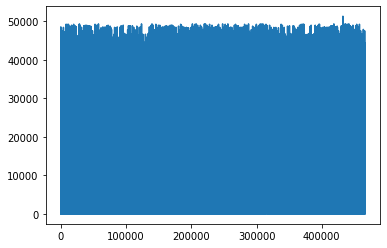

In [125]:
#plt.plot(y_test)
#plt.plot(cat_pred)

## Nearest neighbour features

In [18]:
from sklearn.neighbors import NearestNeighbors


In [70]:
for ix in tr_stock_prices['SecuritiesCode'].unique():
    data = tr_stock_prices[tr_stock_prices['SecuritiesCode']==ix]
    X = (data[feats])
    y = data['Close'].values
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree')
    nbrs.fit(X)
    print(ix)
    break

1301


In [39]:
nbrs.kneighbors(X=[X.values[2]], n_neighbors=4, return_distance=True)

/home/auditor/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[  0.        , 101.17806086, 107.50348832, 202.52901027]]),
 array([[  2, 832, 569,   7]]))

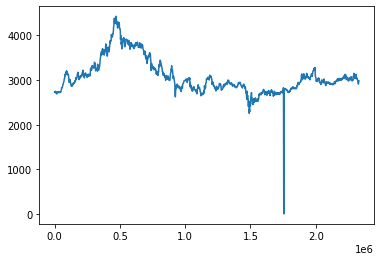

In [49]:
plt.plot(X['Open']);
#plt.plot(X['Volume']);

In [36]:
X

,Open,High,Low,Volume
0,2734.0,2755.0,2730.0,31400
1865,2743.0,2747.0,2735.0,17900
3730,2734.0,2744.0,2720.0,19900
5595,2745.0,2754.0,2735.0,24200
7460,2748.0,2752.0,2737.0,9300
...,...,...,...,...
2322531,2975.0,2984.0,2951.0,14300
2324531,2953.0,2997.0,2900.0,20500
2326531,2909.0,2936.0,2909.0,10600
2328531,2949.0,2973.0,2933.0,15200


## RSI

In [71]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.DataFrame.ewm(u, com=period-1, adjust=False).mean() / \
         pd.DataFrame.ewm(d, com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

def rsi_class(x):
    ret = "low"
    if x < 50:
        ret = "low"
    if x > 50:
        ret = "med"
    if x > 70:
        ret = "hi"
    return(ret)

In [72]:
data = tr_stock_prices[tr_stock_prices['SecuritiesCode']==ix]['Close']
RSI(data, 14)

26110      46.451613
27975      47.185512
29840      45.184785
31705      47.957279
33570      43.861635
             ...    
2322531    38.548082
2324531    34.051847
2326531    35.791435
2328531    39.243291
2330531    46.182943
Name: Close, Length: 1188, dtype: float64

In [121]:
seclist = tr_stock_prices['SecuritiesCode'].unique() #[1301, 1332, 1333, 1376, 1377]
feats = ['Open','High','Low','Volume', 'rsi', 'rsicat']
lr = LinearRegression()
all_lr_preds = []
all_y_test = []
all_mses = []
for SECURITY in seclist:
    df_stock = tr_stock_prices[tr_stock_prices['SecuritiesCode'] == SECURITY].reset_index(drop = True)
    df_stock = df_stock.sort_values(by = "Date").reset_index()
    df_stock['rsi'] = RSI(df_stock['Close'], 14 )
    df_stock['rsicat'] = list(map(rsi_class, df_stock['rsi']))
    df_stock['rsicat'] = pd.Categorical(df_stock['rsicat'])
    df_stock['rsicat'] = df_stock['rsicat'].cat.codes
    X = (df_stock[feats])
    X = prep_prices(X)
    y = df_stock['Close'].values
    y = np.nan_to_num(y, nan=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    lr.fit(X_train,y_train)
    lr_pred = lr.predict(X_test)
    mse = mean_squared_error(y_test, lr_pred)
    
    all_lr_preds.append(lr_pred)
    all_y_test.append(y_test)
    all_mses.append(mse)

/home/auditor/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/auditor/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/auditor/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fil

In [117]:
sum(all_mses)/len(all_mses) # mean ie macro average mse

1653.3097232591433

In [122]:
all_lr_preds = (list(itertools.chain.from_iterable(all_lr_preds)))
all_y_test = ((list(itertools.chain.from_iterable(all_y_test))))
mean_squared_error(all_y_test, all_lr_preds) # micro-average mse

1482.8750589958001

In [119]:
dd = tr_stock_prices[tr_stock_prices['SecuritiesCode'] == 1301].reset_index(drop = True)
dd['rsi'] = RSI(dd['Close'], 14)
dd['rsicat'] = list(map(rsi_class, dd['rsi']))
dd

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rsi,rsicat
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,NaN,low
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,NaN,low
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,NaN,low
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,NaN,low
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,NaN,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,20211129_1301,2021-11-29,1301,2975.0,2984.0,2951.0,2951.0,14300,1.0,NaN,False,0.003793,38.548081,low
1198,20211130_1301,2021-11-30,1301,2953.0,2997.0,2900.0,2900.0,20500,1.0,NaN,False,0.007558,34.051847,low
1199,20211201_1301,2021-12-01,1301,2909.0,2936.0,2909.0,2911.0,10600,1.0,NaN,False,0.016706,35.791435,low
1200,20211202_1301,2021-12-02,1301,2949.0,2973.0,2933.0,2933.0,15200,1.0,NaN,False,-0.003689,39.243290,low
